# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [55]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [56]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/simonhj/My Drive/Kandidat/2. Semester/AI and Machine Learning/mas/MA1/ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [57]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [58]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = mps


### 2. Load data

In [59]:
    # load the training/validation data
train_val = load_torch_data(
        dataset="MNIST",
        root = 'data',                     # The root directory where the dataset will be stored
        download = True,                   # If the dataset is not found at root, it will be downloaded
        train = True,                      # The train dataset (as opposed to the test dataset)
        transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
    )

    # load the testing data
test = load_torch_data(
        dataset = "MNIST",
        root = 'data',
        download = True,
        train = False,
        transform = transforms.ToTensor()
    )

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [60]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [61]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 5


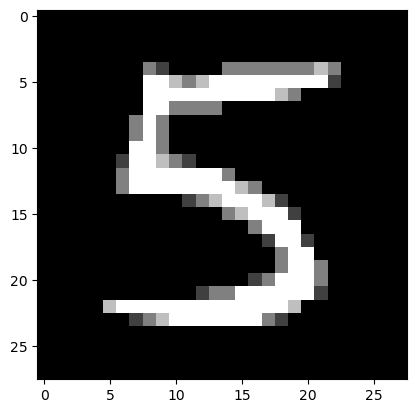

In [62]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [63]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        ######################
        # Fully connected layers
        ######################

        # First layer: Input (28x28 = 784) -> Hidden layer (512 neurons)
        self.fc1 = nn.Linear(28*28, 512)  

        # Second hidden layer: 512 -> 256 neurons
        self.fc2 = nn.Linear(512, 256)

        # Third hidden layer: 256 -> 128 neurons
        self.fc3 = nn.Linear(256, 128)

        # Output layer: 128 -> 10 neurons (digits 0-9)
        self.fc4 = nn.Linear(128, 10)  

        # Activation function
        self.relu = nn.ReLU()

        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.2)  

    def forward(self, x: torch.Tensor):
        ######################
        # Forward pass
        ######################
        x = x.view(x.shape[0], -1)  # Flatten input

        x = self.relu(self.fc1(x))
        x = self.dropout(x)  

        x = self.relu(self.fc2(x))
        x = self.dropout(x)  

        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

### 5. Training hyperparameters

In [64]:
LR = 0.001  # Lower learning rate for Adam (better convergence)
NUM_EPOCHS = 40  # TODO: Define the number of epochs

# The loss function (cross-entropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

# The optimizer (Adam instead of SGD for faster convergence)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Learning rate scheduler (reduces LR every 10 epochs)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Instantiate the model and optimizer

In [65]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [66]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

### 6. Training

In [67]:
model, history = fit(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NUM_EPOCHS
)

# Update scheduler after every epoch
for epoch in range(NUM_EPOCHS):
    scheduler.step()

Epoch [1/40]: Train Loss: 2.3024 | Train Accuracy: 9.71% | Val Loss: 2.2998 | Val Accuracy: 10.65%
Epoch [2/40]: Train Loss: 2.2973 | Train Accuracy: 12.16% | Val Loss: 2.2941 | Val Accuracy: 12.48%
Epoch [3/40]: Train Loss: 2.2919 | Train Accuracy: 14.72% | Val Loss: 2.2877 | Val Accuracy: 15.18%
Epoch [4/40]: Train Loss: 2.2856 | Train Accuracy: 17.99% | Val Loss: 2.2799 | Val Accuracy: 20.70%
Epoch [5/40]: Train Loss: 2.2778 | Train Accuracy: 22.10% | Val Loss: 2.2702 | Val Accuracy: 28.20%
Epoch [6/40]: Train Loss: 2.2676 | Train Accuracy: 29.19% | Val Loss: 2.2575 | Val Accuracy: 40.46%
Epoch [7/40]: Train Loss: 2.2541 | Train Accuracy: 40.71% | Val Loss: 2.2405 | Val Accuracy: 51.48%
Epoch [8/40]: Train Loss: 2.2353 | Train Accuracy: 48.61% | Val Loss: 2.2166 | Val Accuracy: 56.71%
Epoch [9/40]: Train Loss: 2.2083 | Train Accuracy: 51.92% | Val Loss: 2.1819 | Val Accuracy: 57.77%
Epoch [10/40]: Train Loss: 2.1671 | Train Accuracy: 52.57% | Val Loss: 2.1286 | Val Accuracy: 56.98%


/opt/anaconda3/envs/aiml25-ma1/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


### 7. Plot loss and accuracy

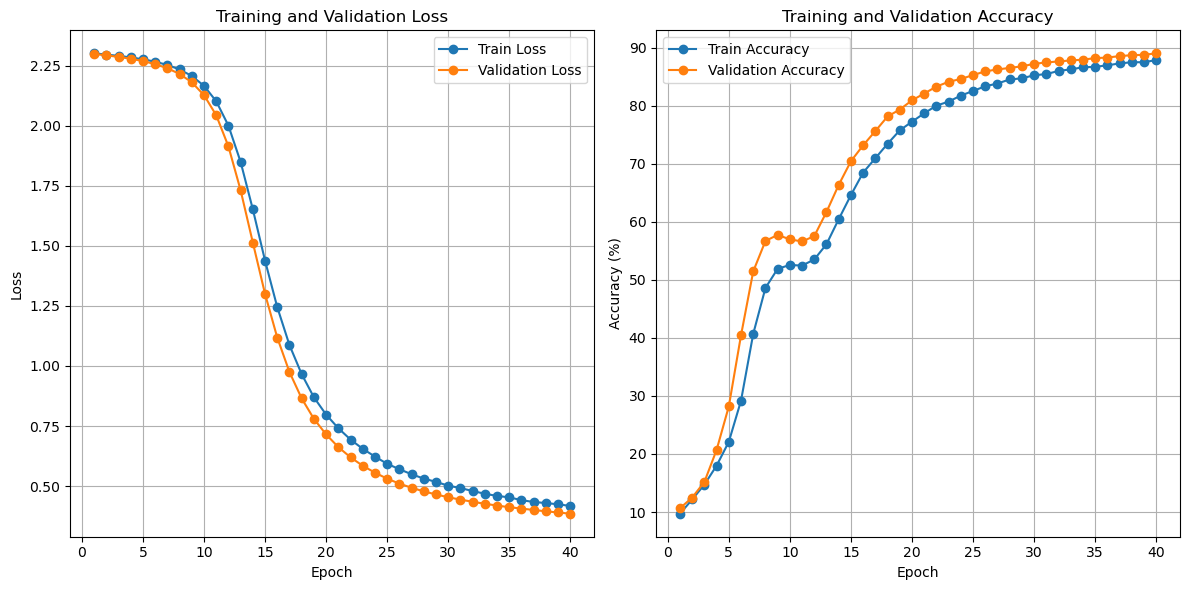

In [68]:
plot_training_history(history)

### 8. Evaluate

In [69]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.3668, Accuracy: 89.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4735
           1       0.93      0.97      0.95      5383
           2       0.90      0.86      0.88      4762
           3       0.88      0.87      0.88      4886
           4       0.90      0.91      0.91      4681
           5       0.87      0.81      0.83      4368
           6       0.91      0.94      0.93      4752
           7       0.92      0.91      0.91      4983
           8       0.85      0.85      0.85      4674
           9       0.86      0.86      0.86      4776

    accuracy                           0.90     48000
   macro avg       0.89      0.89      0.89     48000
weighted avg       0.90      0.90      0.90     48000



In [70]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.3847, Accuracy: 89.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1188
           1       0.94      0.96      0.95      1359
           2       0.89      0.84      0.87      1196
           3       0.86      0.87      0.87      1245
           4       0.89      0.91      0.90      1161
           5       0.85      0.82      0.83      1053
           6       0.91      0.93      0.92      1166
           7       0.91      0.91      0.91      1282
           8       0.86      0.86      0.86      1177
           9       0.84      0.83      0.84      1173

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000



In [71]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.3577, Accuracy: 89.67%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.97      0.97      1135
           2       0.91      0.86      0.89      1032
           3       0.87      0.89      0.88      1010
           4       0.88      0.92      0.90       982
           5       0.86      0.80      0.83       892
           6       0.91      0.92      0.92       958
           7       0.92      0.89      0.91      1028
           8       0.85      0.84      0.85       974
           9       0.87      0.86      0.86      1009

    accuracy                           0.90     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000

